## Module 5 Class activities
This notebook is a starting point for the exercises and activities that we'll do in class. We'll do an extension of the random forests classifier, looking at a continuous variable.

Before you attempt any of these activities, make sure to watch the video lectures for this module.

### Classification: NYC evictions
We'll look at the factors that are associated with evictions in New York City. Perhaps a machine learning model can identify the types of places that are vulnerable to eviction, and target renter assistance programs more effectively?

#### Loading in the data

Let's start by loading in the [eviction dataset](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4) via Socrata.

<div class="alert alert-block alert-info">

<strong>Exercise:</strong> Import the data from Socrata via the API into a pandas DataFrame.
</div>

*Hints*:
- Look back at Week 1 if you need a refresher on using Socrata
- There are about 70,000 rows in the dataset. So remember to add `?$limit=100000` to the end of the URL that you pass to `requests.get()`. Otherwise, you'll just get the first 1,000 rows. (The limit can be anything comfortably above 70000.)

In [1]:
import requests
import json
import pandas as pd
import geopandas as gpd

# your code here
url = 'https://data.cityofnewyork.us/resource/6z8x-wfk4.json?$limit=100000'
r = requests.get(url)
df = pd.DataFrame(json.loads(r.text))
df.head(2)

,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip,ejectment,eviction_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,59167/16-1,288143,83-40 BRITTON AVENUE,04C,2017-06-16T00:00:00.000,George,Essock,Residential,QUEENS,11373,Not an Ejectment,Possession,40.744209,-73.881522,4,25,271,4037494,4015170021,Elmhurst
1,Q56705/18,088658,108-50 153RD STREET,NaN,2018-08-17T00:00:00.000,Ileana,Rivera,Residential,QUEENS,11433,Not an Ejectment,Possession,40.692432,-73.797564,12,28,254,4216044,4101410018,South Jamaica


<div class="alert alert-block alert-info">

<strong>Exercise:</strong> Convert your dataframe to a GeoDataFrame, using the latitude and longitude columns.

In [2]:
# your code here 
Gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude, 
                                          crs='EPSG:4326'))
Gdf.head(2)

,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip,...,eviction_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,geometry
0,59167/16-1,288143,83-40 BRITTON AVENUE,04C,2017-06-16T00:00:00.000,George,Essock,Residential,QUEENS,11373,...,Possession,40.744209,-73.881522,4,25,271,4037494,4015170021,Elmhurst,POINT (-73.88152 40.74421)
1,Q56705/18,088658,108-50 153RD STREET,NaN,2018-08-17T00:00:00.000,Ileana,Rivera,Residential,QUEENS,11433,...,Possession,40.692432,-73.797564,12,28,254,4216044,4101410018,South Jamaica,POINT (-73.79756 40.69243)


Now let's import some census data. We could use `cenpy` or the Census Bureau API. But to keep things simple so that we can focus on the spatial joins and the machine learning, I downloaded the block group-level 2019 ACS data for New York from the [Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.html). To save space, I clipped it to the 5 NYC counties.

It's in your repository, and we can load it in as follows. If you aren't familiar with a GeoPackage (GPKG) format, think of it as a "new and improved shapefile." [Here's a good overview.](https://towardsdatascience.com/why-you-need-to-use-geopackage-files-instead-of-shapefile-or-geojson-7cb24fe56416)

In [19]:
bgs = gpd.read_file('data/nyc_bgs.gpkg')
bgs.head(2)

,GEOID,B01001e1,B01001e10,B01001e11,B01001e12,B01001e13,B01001e14,B01001e15,B01001e16,B01001e17,B01001e18,B01001e19,B02001e1,B02001e10,B02001e2,B02001e3,B02001e4,B02001e5,B02001e6,B02001e7,B02001e8,B02001e9,B03002e12,B03002e3,B09002e1,B09002e10,B09002e11,B09002e12,B09002e13,B09002e14,B09002e15,B09002e16,B09002e17,B09002e18,B09002e19,B09002e2,B09002e20,B09002e3,B09002e4,B09002e5,B09002e6,B09002e7,B09002e8,B09002e9,B09019e1,B09019e10,B09019e11,B09019e12,B09019e13,B09019e14,B09019e15,B09019e16,B09019e17,B09019e18,B09019e19,B09019e2,B09019e20,B09019e21,B09019e22,B09019e23,B09019e24,B09019e25,B09019e26,B09019e3,B09019e4,B09019e5,B09019e6,B09019e7,B09019e8,B09019e9,B09021e1,B09021e10,B09021e11,B09021e12,B09021e13,B09021e14,B09021e15,B09021e16,B09021e17,B09021e18,B09021e19,B09021e2,B09021e20,B09021e21,B09021e22,B09021e23,B09021e24,B09021e25,B09021e26,B09021e27,B09021e28,B09021e3,B09021e4,B09021e5,B09021e6,B09021e7,B09021e8,B09021e9,B11001e1,B11001e2,B11001e3,B11001e4,B11001e5,B11001e6,B11001e7,B11001e8,B11001e9,B11005e1,B11005e10,B11005e11,B11005e12,B11005e13,B11005e14,B11005e15,B11005e16,B11005e17,B11005e18,B11005e19,B11005e2,B11005e3,B11005e4,B11005e5,B11005e6,B11005e7,B11005e8,B11005e9,B11012e1,B11012e10,B11012e11,B11012e12,B11012e13,B11012e14,B11012e15,B11012e16,B11012e17,B11012e2,B11012e3,B11012e4,B11012e5,B11012e6,B11012e7,B11012e8,B11012e9,B11016e1,B11016e10,B11016e11,B11016e12,B11016e13,B11016e14,B11016e15,B11016e16,B11016e2,B11016e3,B11016e4,B11016e5,B11016e6,B11016e7,B11016e8,B11016e9,B17010e1,B17010e10,B17010e11,B17010e12,B17010e13,B17010e14,B17010e15,B17010e16,B17010e17,B17010e18,B17010e19,B17010e2,B17010e20,B17010e21,B17010e22,B17010e23,B17010e24,B17010e25,B17010e26,B17010e27,B17010e28,B17010e29,B17010e3,B17010e30,B17010e31,B17010e32,B17010e33,B17010e34,B17010e35,B17010e36,B17010e37,B17010e38,B17010e39,B17010e4,B17010e40,B17010e41,B17010e5,B17010e6,B17010e7,B17010e8,B17010e9,B17017e1,B17017e10,B17017e11,B17017e12,B17017e13,B17017e14,B17017e15,B17017e16,B17017e17,B17017e18,B17017e19,B17017e2,B17017e20,B17017e21,B17017e22,B17017e23,B17017e24,B17017e25,B17017e26,B17017e27,B17017e28,B17017e29,B17017e3,B17017e30,B17017e31,B17017e32,B17017e33,B17017e34,B17017e35,B17017e36,B17017e37,B17017e38,B17017e39,B17017e4,B17017e40,B17017e41,B17017e42,B17017e43,B17017e44,B17017e45,B17017e46,B17017e47,B17017e48,B17017e49,B17017e5,B17017e50,B17017e51,B17017e52,B17017e53,B17017e54,B17017e55,B17017e56,B17017e57,B17017e58,B17017e59,B17017e6,B17017e7,B17017e8,B17017e9,B19001e1,B19001e10,B19001e11,B19001e12,B19001e13,B19001e14,B19001e15,B19001e16,B19001e17,B19001e2,B19001e3,B19001e4,B19001e5,B19001e6,B19001e7,B19001e8,B19001e9,B22010e1,B22010e2,B22010e3,B22010e4,B22010e5,B22010e6,B22010e7,geometry
0,15000US360050175002,656,39,0,0,0,18,14,0,22,0,0,656,0,34,358,60,0,0,204,0,0,537,0,66,0,0,0,0,0,0,0,0,0,0,66,0,0,0,17,17,32,0,0,656,65,0,0,0,175,159,0,16,58,0,656,0,0,0,0,0,0,0,358,50,0,50,308,196,112,571,0,0,69,39,0,226,19,92,0,40,196,75,0,237,177,38,0,0,22,0,130,0,109,136,0,108,0,358,162,65,97,0,97,196,196,0,358,0,327,131,50,81,0,81,196,0,196,31,31,15,16,0,16,0,0,358,0,97,0,0,0,0,0,0,65,15,50,0,0,0,293,196,358,196,0,0,0,0,0,0,162,98,49,0,0,15,0,196,162,0,0,0,0,0,0,0,0,0,0,17,0,0,145,48,15,0,0,15,33,97,17,0,0,0,0,0,0,97,16,16,0,0,0,81,0,0,0,17,0,358,0,0,0,0,0,0,0,0,0,0,165,148,0,0,0,0,0,148,0,0,19,17,129,193,145,48,0,15,22,11,97,0,17,0,0,0,0,97,0,0,75,22,48,0,0,0,0,0,0,48,0,0,0,48,0,0,17,0,358,59,0,37,0,0,0,0,0,57,108,0,22,16,48,11,0,358,214,139,75,144,107,37,"POLYGON ((-73.91570 40.83054, -73.91485 40.830..."
1,15000US360050141001,1228,0,35,96,26,45,28,0,54,0,8,1228,12,133,290,0,9,0,750,46,34,925,0,277,0,0,18,23,22,170,20,10,18,52,44,70,14,0,0,22,8,233,63,1228,50,0,20,0,459,459,0,0,111,17,1228,24,0,0,22,0,22,0,503,164,71,93,339,120,219,855,22,18,182,50,0,400,86,56,20,0,191,218,20,153,75,22,0,0,56,0,100,38,182,324,20,302,30,503,292,50,242,71,171,211,191,20,503,20,312,121,31,90,22,68,191,71,120,191,171,19,152,49,103,20,0,503,53,100,20,142,71,49,22,0,5

Note that the variables aren't particularly carefully selected - I just threw in many of the demographic and housing variables. 

Nor are the variable names particularly informative, but the full names are in a file in the repository.

In [4]:
# note it is tab-sepated, not comma separated
# so we use the sep='\t' argument

col_names = pd.read_csv('data/BG_METADATA_2019.txt', sep='\t', index_col='Short_Name')
col_names

,Full_Name
Short_Name,
B01001e1,SEX BY AGE: Total: Total population -- (Estimate)
B01001m1,SEX BY AGE: Total: Total population -- (Margin...
B01001e2,SEX BY AGE: Male: Total population -- (Estimate)
B01001m2,SEX BY AGE: Male: Total population -- (Margin ...
B01001e3,SEX BY AGE: Male: Under 5 years: Total populat...
...,...
B99283m3,ALLOCATION OF HOUSEHOLD INTERNET SUBSCRIPTION ...
B99283e4,ALLOCATION OF HOUSEHOLD INTERNET SUBSCRIPTION ...
B99283m4,ALLOCATION OF HOUSEHOLD INTERNET SUBSCRIPTION ...


So you can see the definition of the column like this. (I don't recommend renaming the `bg` column names, because the full names are so long.)

In [5]:
col_names.loc['B01001e1']

Full_Name    SEX BY AGE: Total: Total population -- (Estimate)
Name: B01001e1, dtype: object

#### Spatial join
Now let's do the spatial join. Again, let's follow our three step process.

1. Use a spatial join to add the `GEOID` column to the evictions dataframe. *Hint:* Check your projections.
2. Group by `GEOID` to get a count of evictions per block group. If you have a `Series`, give it a name - maybe `n_evictions`
3. Join those counts back - a tabular join based on the index

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Add a count of evictions per census block group to your <strong>bgs</strong> GeoDataFrame, using the 3-step process above.
</div>

In [6]:
# your code here
joinGDF = gpd.sjoin(bgs[['GEOID','geometry']].to_crs('EPSG:4326'),
                           Gdf.to_crs('EPSG:4326'), how='right', predicate='contains')
joinGDF.head(2)

,index_left,GEOID,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,...,eviction_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,geometry
0,6466.0,15000US360810271004,59167/16-1,288143,83-40 BRITTON AVENUE,04C,2017-06-16T00:00:00.000,George,Essock,Residential,...,Possession,40.744209,-73.881522,4,25,271,4037494,4015170021,Elmhurst,POINT (-73.88152 40.74421)
1,1064.0,15000US360810254006,Q56705/18,088658,108-50 153RD STREET,NaN,2018-08-17T00:00:00.000,Ileana,Rivera,Residential,...,Possession,40.692432,-73.797564,12,28,254,4216044,4101410018,South Jamaica,POINT (-73.79756 40.69243)


In [7]:
# joinGDF.info()
joinGDF_n = joinGDF.groupby(['GEOID']).size()
joinGDF_n.name = 'n_evictions'
joinGDF_n

GEOID
15000US360050002001    10
15000US360050002002    17
15000US360050002003     6
15000US360050004001     7
15000US360050004002    17
                       ..
15000US360850319012    12
15000US360850319021    63
15000US360850319022    22
15000US360850319023    23
15000US360850323001    17
Name: n_evictions, Length: 5791, dtype: int64

In [8]:
joinGDF_bgs = bgs.join(joinGDF_n, how = 'left', on = 'GEOID')
pd.set_option('display.max_columns', None)
joinGDF_bgs.head(2)
# joinedDf = censusDf.join(hesitancy2, rsuffix='_hesitancy')

,GEOID,B01001e1,B01001e10,B01001e11,B01001e12,B01001e13,B01001e14,B01001e15,B01001e16,B01001e17,B01001e18,B01001e19,B02001e1,B02001e10,B02001e2,B02001e3,B02001e4,B02001e5,B02001e6,B02001e7,B02001e8,B02001e9,B03002e12,B03002e3,B09002e1,B09002e10,B09002e11,B09002e12,B09002e13,B09002e14,B09002e15,B09002e16,B09002e17,B09002e18,B09002e19,B09002e2,B09002e20,B09002e3,B09002e4,B09002e5,B09002e6,B09002e7,B09002e8,B09002e9,B09019e1,B09019e10,B09019e11,B09019e12,B09019e13,B09019e14,B09019e15,B09019e16,B09019e17,B09019e18,B09019e19,B09019e2,B09019e20,B09019e21,B09019e22,B09019e23,B09019e24,B09019e25,B09019e26,B09019e3,B09019e4,B09019e5,B09019e6,B09019e7,B09019e8,B09019e9,B09021e1,B09021e10,B09021e11,B09021e12,B09021e13,B09021e14,B09021e15,B09021e16,B09021e17,B09021e18,B09021e19,B09021e2,B09021e20,B09021e21,B09021e22,B09021e23,B09021e24,B09021e25,B09021e26,B09021e27,B09021e28,B09021e3,B09021e4,B09021e5,B09021e6,B09021e7,B09021e8,B09021e9,B11001e1,B11001e2,B11001e3,B11001e4,B11001e5,B11001e6,B11001e7,B11001e8,B11001e9,B11005e1,B11005e10,B11005e11,B11005e12,B11005e13,B11005e14,B11005e15,B11005e16,B11005e17,B11005e18,B11005e19,B11005e2,B11005e3,B11005e4,B11005e5,B11005e6,B11005e7,B11005e8,B11005e9,B11012e1,B11012e10,B11012e11,B11012e12,B11012e13,B11012e14,B11012e15,B11012e16,B11012e17,B11012e2,B11012e3,B11012e4,B11012e5,B11012e6,B11012e7,B11012e8,B11012e9,B11016e1,B11016e10,B11016e11,B11016e12,B11016e13,B11016e14,B11016e15,B11016e16,B11016e2,B11016e3,B11016e4,B11016e5,B11016e6,B11016e7,B11016e8,B11016e9,B17010e1,B17010e10,B17010e11,B17010e12,B17010e13,B17010e14,B17010e15,B17010e16,B17010e17,B17010e18,B17010e19,B17010e2,B17010e20,B17010e21,B17010e22,B17010e23,B17010e24,B17010e25,B17010e26,B17010e27,B17010e28,B17010e29,B17010e3,B17010e30,B17010e31,B17010e32,B17010e33,B17010e34,B17010e35,B17010e36,B17010e37,B17010e38,B17010e39,B17010e4,B17010e40,B17010e41,B17010e5,B17010e6,B17010e7,B17010e8,B17010e9,B17017e1,B17017e10,B17017e11,B17017e12,B17017e13,B17017e14,B17017e15,B17017e16,B17017e17,B17017e18,B17017e19,B17017e2,B17017e20,B17017e21,B17017e22,B17017e23,B17017e24,B17017e25,B17017e26,B17017e27,B17017e28,B17017e29,B17017e3,B17017e30,B17017e31,B17017e32,B17017e33,B17017e34,B17017e35,B17017e36,B17017e37,B17017e38,B17017e39,B17017e4,B17017e40,B17017e41,B17017e42,B17017e43,B17017e44,B17017e45,B17017e46,B17017e47,B17017e48,B17017e49,B17017e5,B17017e50,B17017e51,B17017e52,B17017e53,B17017e54,B17017e55,B17017e56,B17017e57,B17017e58,B17017e59,B17017e6,B17017e7,B17017e8,B17017e9,B19001e1,B19001e10,B19001e11,B19001e12,B19001e13,B19001e14,B19001e15,B19001e16,B19001e17,B19001e2,B19001e3,B19001e4,B19001e5,B19001e6,B19001e7,B19001e8,B19001e9,B22010e1,B22010e2,B22010e3,B22010e4,B22010e5,B22010e6,B22010e7,geometry,n_evictions
0,15000US360050175002,656,39,0,0,0,18,14,0,22,0,0,656,0,34,358,60,0,0,204,0,0,537,0,66,0,0,0,0,0,0,0,0,0,0,66,0,0,0,17,17,32,0,0,656,65,0,0,0,175,159,0,16,58,0,656,0,0,0,0,0,0,0,358,50,0,50,308,196,112,571,0,0,69,39,0,226,19,92,0,40,196,75,0,237,177,38,0,0,22,0,130,0,109,136,0,108,0,358,162,65,97,0,97,196,196,0,358,0,327,131,50,81,0,81,196,0,196,31,31,15,16,0,16,0,0,358,0,97,0,0,0,0,0,0,65,15,50,0,0,0,293,196,358,196,0,0,0,0,0,0,162,98,49,0,0,15,0,196,162,0,0,0,0,0,0,0,0,0,0,17,0,0,145,48,15,0,0,15,33,97,17,0,0,0,0,0,0,97,16,16,0,0,0,81,0,0,0,17,0,358,0,0,0,0,0,0,0,0,0,0,165,148,0,0,0,0,0,148,0,0,19,17,129,193,145,48,0,15,22,11,97,0,17,0,0,0,0,97,0,0,75,22,48,0,0,0,0,0,0,48,0,0,0,48,0,0,17,0,358,59,0,37,0,0,0,0,0,57,108,0,22,16,48,11,0,358,214,139,75,144,107,37,"POLYGON ((-73.91570 40.83054, -73.91485 40.830...",26.0
1,15000US360050141001,1228,0,35,96,26,45,28,0,54,0,8,1228,12,133,290,0,9,0,750,46,34,925,0,277,0,0,18,23,22,170,20,10,18,52,44,70,14,0,0,22,8,233,63,1228,50,0,20,0,459,459,0,0,111,17,1228,24,0,0,22,0,22,0,503,164,71,93,339,120,219,855,22,18,182,50,0,400,86,56,20,0,191,218,20,153,75,22,0,0,56,0,100,38,182,324,20,302,30,503,292,50,242,71,171,211,191,20,503,20,312,121,31,90,22,68,191,71,120,191,171,19,152,49,103,20,0,503,53,100,20

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Do a quick-and-dirty map of the number of evictions. This will help identify any data holes.
</div>

<Axes: >

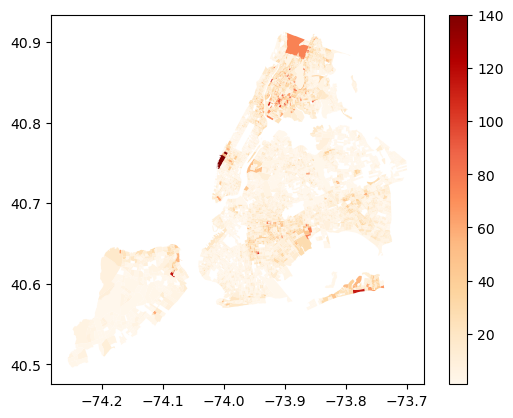

In [9]:
# your code here
joinGDF_bgs.plot('n_evictions',cmap='OrRd', legend=True)

#### Random forests regressor
Now we have our data set. Let's estimate a random forests model.

In contrast to the examples in the lecture, we are trying to predict a continuous variable - the number of evictions. So our classifier isn't appropriate. 

However, there is a similar model: the [random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). It works almost identically to the classifier. The main difference from a user perspective is assessing model performance - a confusion matrix doesn't work here.

You'll need to follow the following steps:
- choose your x variables. (Your y variable will be `n_evictions`)
- Drop Null values if needed
- split your dataset into training and testing portions
- estimate (fit) the model

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Estimate a random forest regressor model to predict the number of evictions per census tract.</div>

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# your code here
print(col_names.loc[['B01001e1','B02001e3','B17010e1','B22010e2']])

# choose your x variables
xvars = ['B01001e1', 'B02001e3', 'B17010e1','B22010e2']
yvar = 'n_evictions'

                                                    Full_Name
Short_Name                                                   
B01001e1    SEX BY AGE: Total: Total population -- (Estimate)
B02001e3    RACE: Total: Black or African American alone: ...
B17010e1    POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...
B22010e2    RECEIPT OF FOOD STAMPS/SNAP IN THE PAST 12 MON...


In [11]:
# create a dataframe with no NaNs
joinGDF_bgs_fit = joinGDF_bgs[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    joinGDF_bgs_fit[xvars], joinGDF_bgs_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

4343 4343
1448 1448


In [12]:
# initialize the random forest classifer object
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=1)

In [13]:
y_pred = rf.predict(X_test)
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 11.8111. Actual fraction True: 11.3184


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Examine some of your trees in the random forest. What do they tell you?</div>

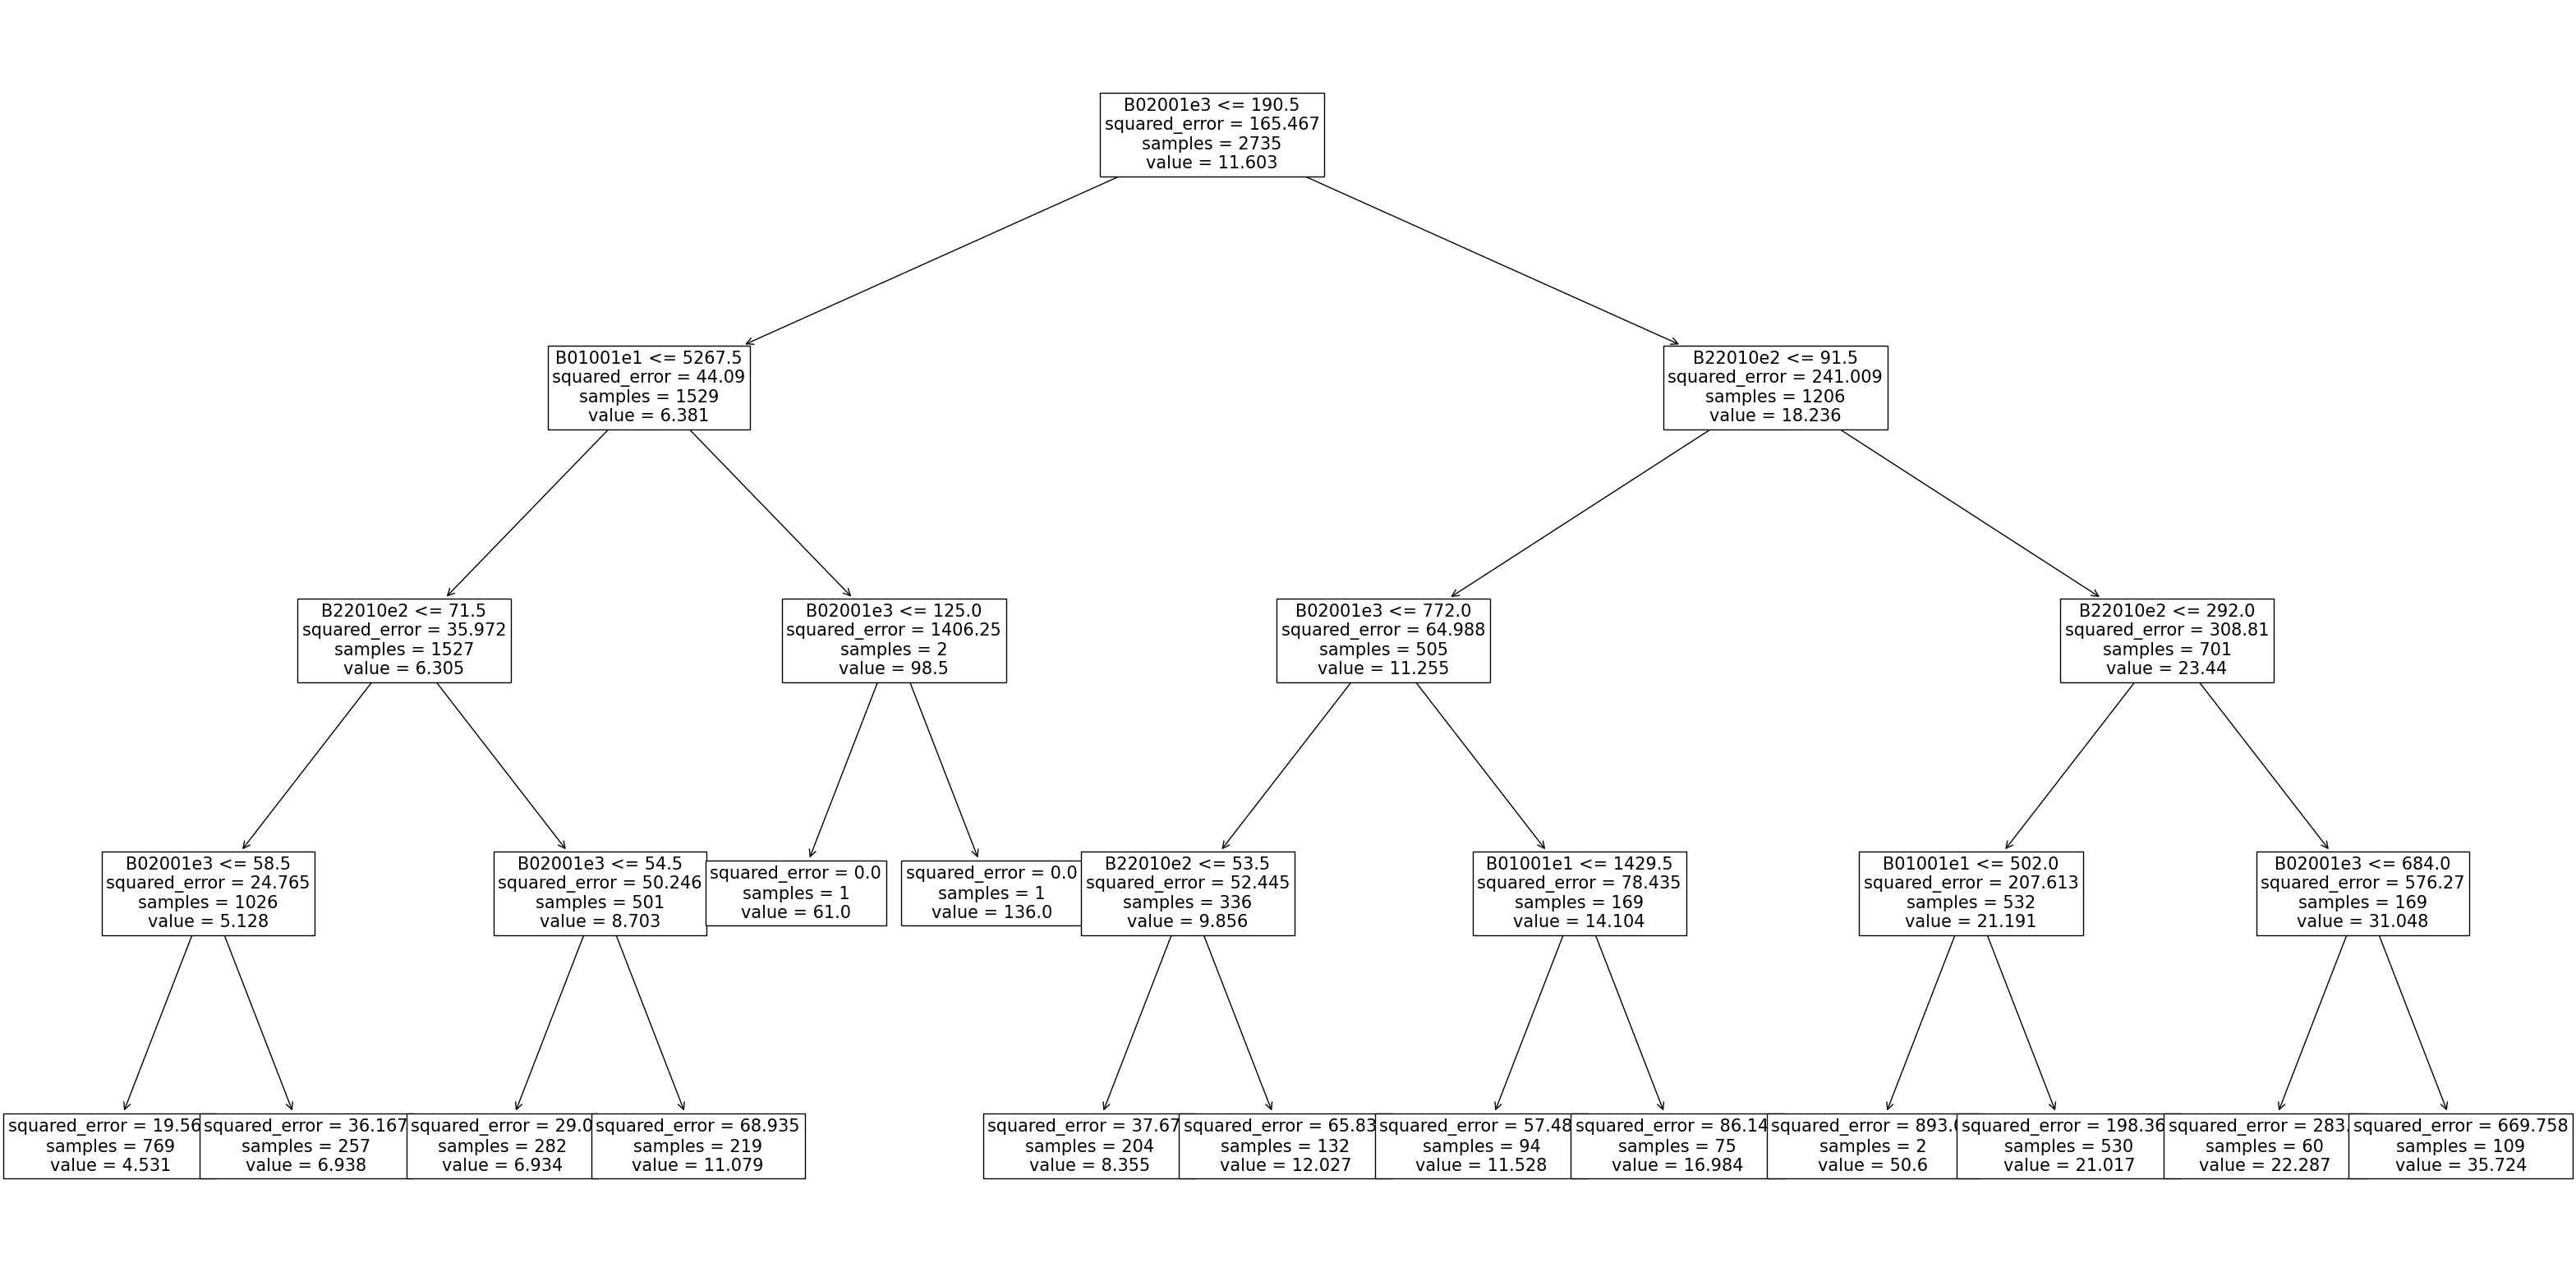

In [14]:
# your code here

rf = RandomForestRegressor(n_estimators = 50, random_state = 1, n_jobs=-1, max_depth=4) 
rf.fit(X_train, y_train)

# now we have 50 estimators (trees), so let's pick the first one to visualize
e = rf.estimators_[0]

from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

In [15]:
# get a list of the decision trees in the Random Forest
trees = rf.estimators_

# examine the first three trees in the list
for i in range(3):
    print('Tree', i+1, ':')
    tree = trees[i]
    # print the tree structure
    print(tree.tree_)
    # print the feature importances
    print('Feature importances:', tree.feature_importances_)
    print()

Tree 1 :
Feature importances: [0.0798822  0.58840818 0.         0.33170962]

Tree 2 :
Feature importances: [0.06751689 0.57232081 0.01048332 0.34967897]

Tree 3 :
Feature importances: [0.09857328 0.57053263 0.         0.33089408]



<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Experiment with different model hyperparameters and variables. Discuss your rationale and the results with a neighbor.</div>

In [25]:
print(col_names.loc[['B02001e5','B09002e1','B11012e3','B17010e2','B22010e2']])

                                                    Full_Name
Short_Name                                                   
B02001e5    RACE: Total: Asian alone: Total population -- ...
B09002e1    OWN CHILDREN UNDER 18 YEARS BY FAMILY TYPE AND...
B11012e3    HOUSEHOLDS BY TYPE: Married-couple household: ...
B17010e2    POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...
B22010e2    RECEIPT OF FOOD STAMPS/SNAP IN THE PAST 12 MON...


In [26]:
# your code here
# choose your x variables
xvars2 = ['B02001e5', 'B09002e1', 'B11012e3','B17010e2','B22010e2']
yvar = 'n_evictions'


# create a dataframe with no NaNs
joinGDF_bgs_fit2 = joinGDF_bgs[xvars2+[yvar]].dropna()

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    joinGDF_bgs_fit2[xvars2], joinGDF_bgs_fit2[yvar], test_size = 0.25, random_state = 1)

Predicted fraction True: 12.0741. Actual fraction True: 11.3184


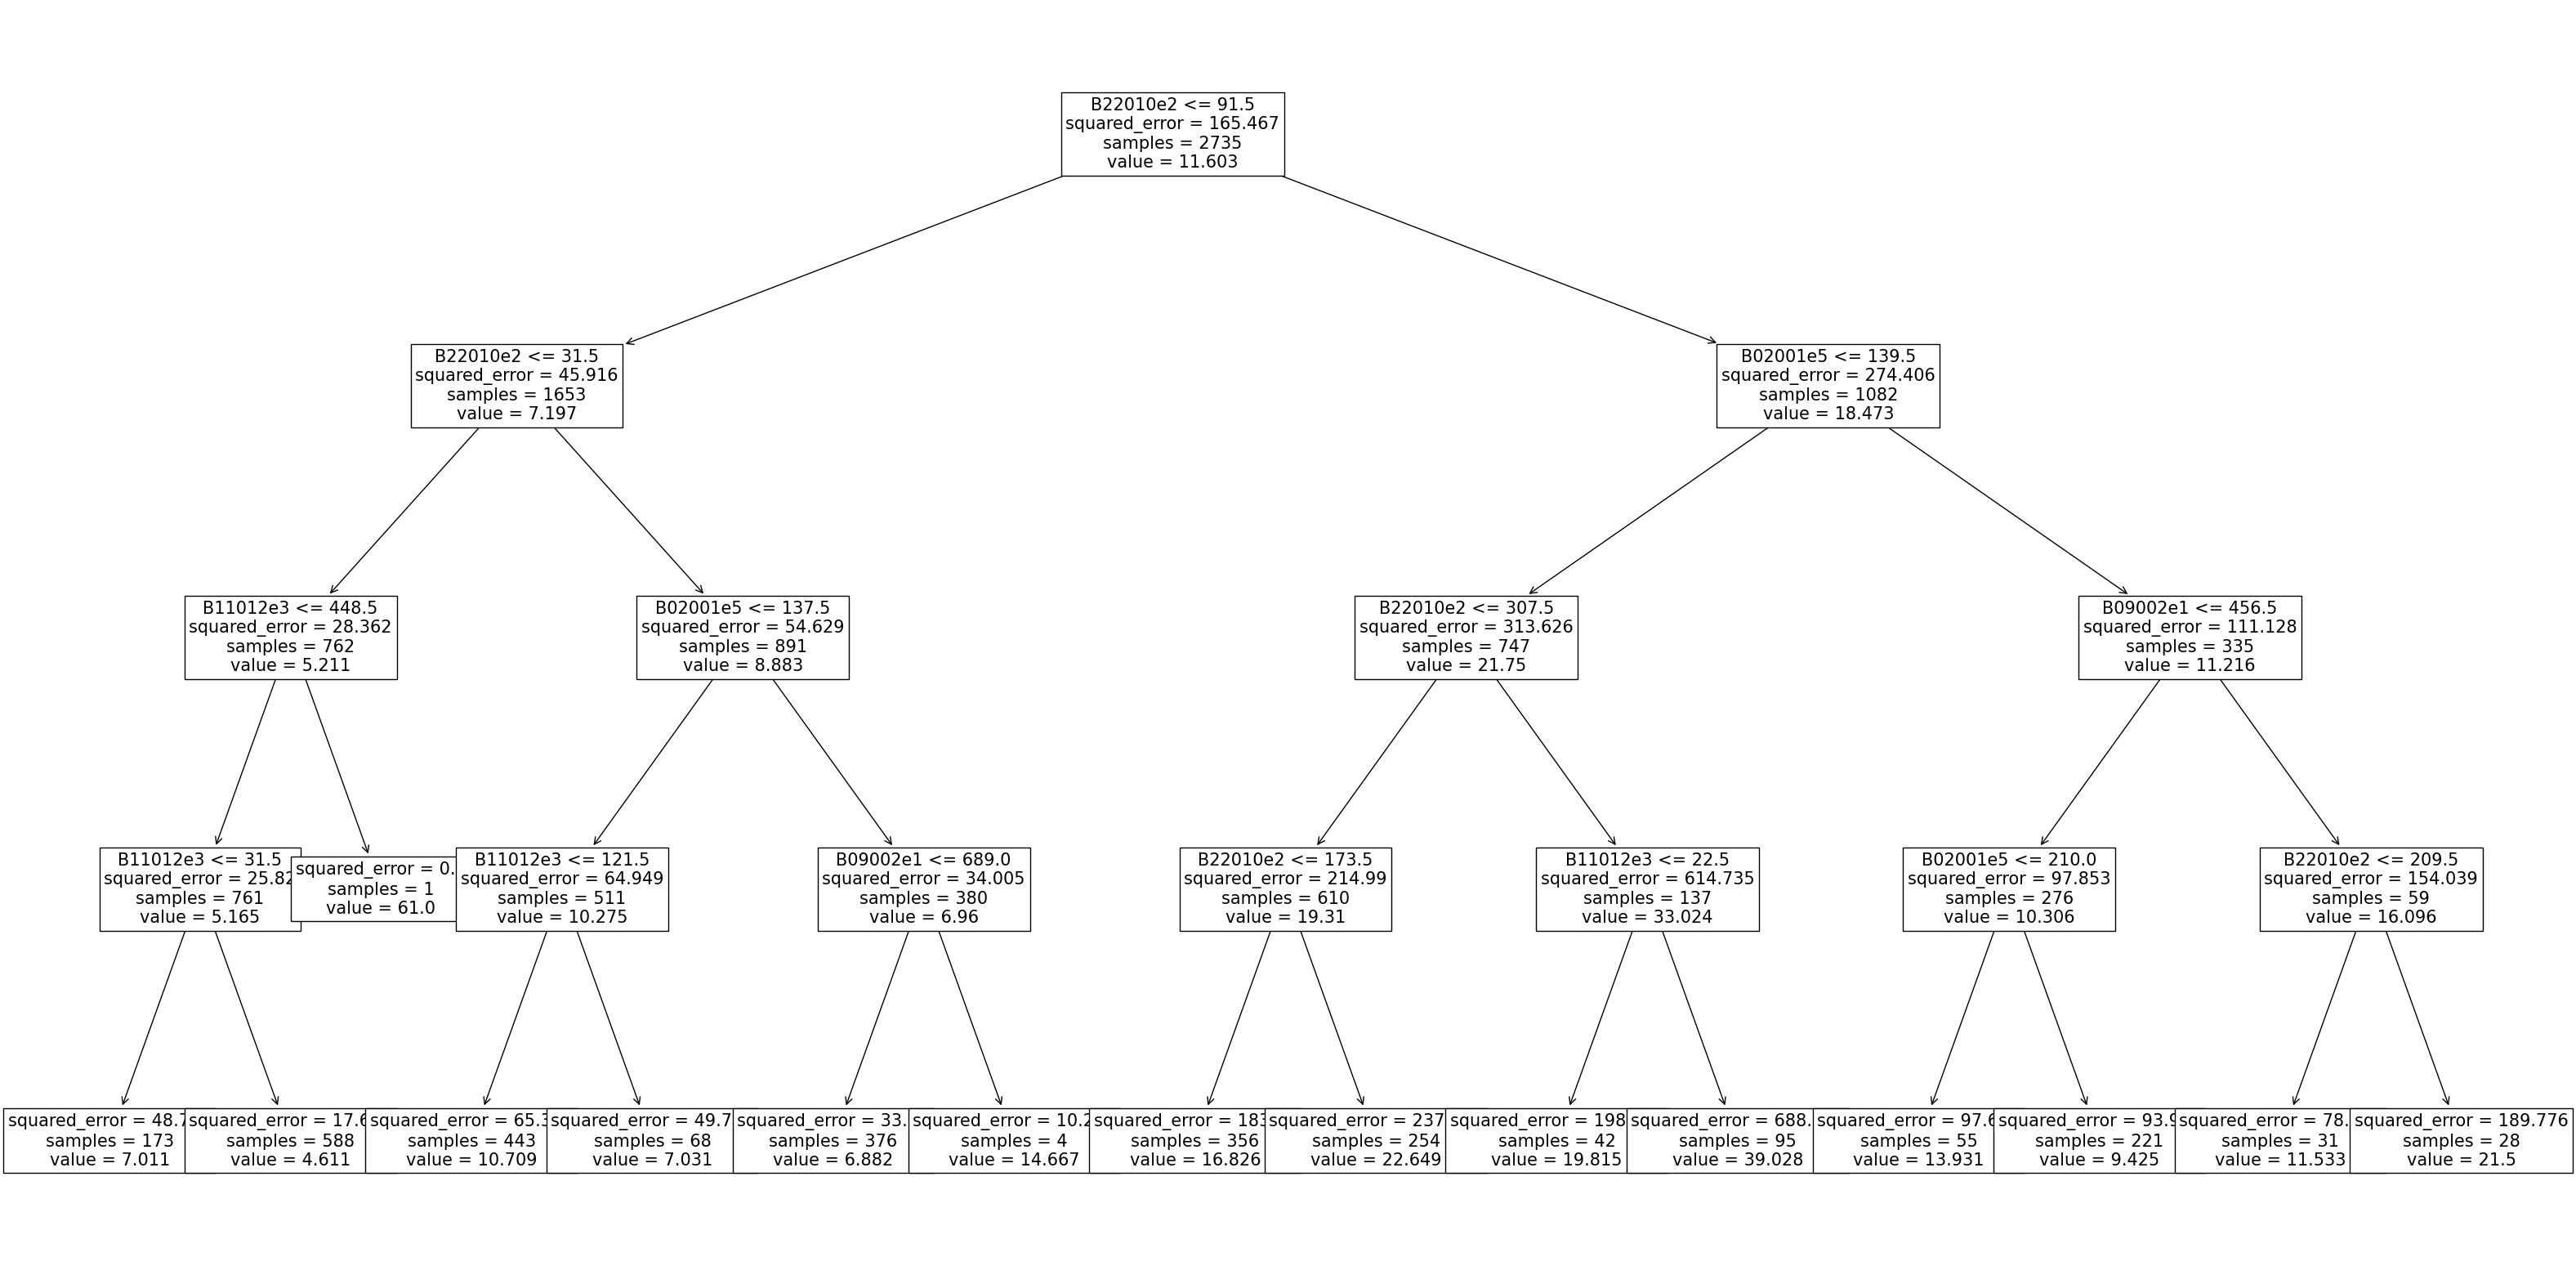

In [40]:
# initialize the random forest classifer object
rf2 = RandomForestRegressor(n_estimators = 100, random_state = 1)

# now fit the model
rf2.fit(X_train2, y_train2)

y_pred2 = rf2.predict(X_test2)
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred2.mean(), y_test2.mean()))

rf2= RandomForestRegressor(n_estimators = 100, random_state = 1, n_jobs=-1, max_depth=4) 
rf2.fit(X_train2, y_train2)

# now we have 50 estimators (trees), so let's pick the first one to visualize
e = rf2.estimators_[0]

from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train2.columns, fontsize=15, ax = ax)

The following questions relate to some of the material in Module 6. You might want to wait until watching those lectures. Then come back and complete these tasks.

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Assess the fit of your model.</div>

Remember, the confusion matrix and accuracy scores don't apply to continuous data. Some ideas for continuous variables are [here](https://stackoverflow.com/questions/50789508/random-forest-regression-how-do-i-analyse-its-performance-python-sklearn). You could also plot actual vs predicted values.

In [37]:
import numpy as np

# check unique values of y_test2
print('Unique values of y_test2:', np.unique(y_test2))

# check unique values of y_pred2
print('Unique values of y_pred2:', np.unique(y_pred2))

Unique values of y_test2: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  49.  50.  51.  52.  53.  54.  56.  57.  60.
  63.  64.  67.  68.  69.  70.  78.  87.  89.  93. 140.]
Unique values of y_pred2: [ 2.11  2.13  2.16 ... 56.49 57.81 60.33]


In [39]:
# your code here
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test2, y_pred2))

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test2, y_pred2)))
print(classification_report(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Which variables are most important in your predictions? Plot the forest importances.</div>

Text(0, 0.5, 'Mean decrease in impurity')

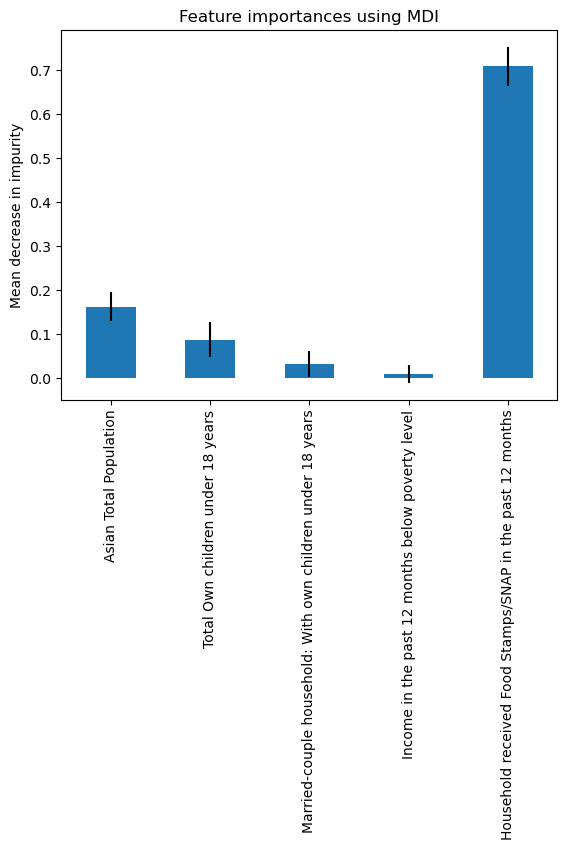

In [43]:
# your code here
import numpy as np
import matplotlib.pyplot as plt
importances = rf2.feature_importances_

# Change X_train2 column name 
X_train2.columns = ['Asian Total Population', 
                    'Total Own children under 18 years', 
                    'Married-couple household: With own children under 18 years', 
                    'Income in the past 12 months below poverty level',
                    'Household received Food Stamps/SNAP in the past 12 months']

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train2.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


<div class="alert alert-block alert-info">
<h3>What you should have learned</h3>
<ul>
  <li>Get more practice with spatial joins and Socrata.</li>
  <li>Learn how to estimate a random forests model for continuous data.</li>
</ul>
</div>